# Lab 3: Linearisation and phase portraits

By the end of this Lab, we will be using Python to produce phase portraits for different $2\times2$ systems of ODEs. This will be a good opportunity for you to review theory from the lectures, and to revisit some of the workshop problems.

Before producing phase portraits, we will recap some of the theory from earlier in the course, about producing solutions for systems of ODEs defined by a matrix equation, and about linearising nonlinear equations.

## 1. Matrix solutions 

To get started, we will revisit Q1 from the Week 3 workshop sheet, and use Python to find the general solution for the system. (You may also want to open the model solutions for the workshop sheet, to follow the method.) 

***
### Example
Find the general solution of the system of ODEs given by the matrix equation:

$$\mathbf{x}'=\begin{bmatrix}3 & -4 \\ 1 & -1\end{bmatrix}\mathbf{x}.$$
***

Recall from Lab 1 that we can use SymPy to find the eigenvalues and eigenvectors:

In [4]:
import sympy as sym
sym.init_printing()
from IPython.display import display_latex

M = sym.Matrix([[3,-4],[1,-1]])
evs = M.eigenvects()
evs

⎡⎛      ⎡⎡2⎤⎤⎞⎤
⎢⎜1, 2, ⎢⎢ ⎥⎥⎟⎥
⎣⎝      ⎣⎣1⎦⎦⎠⎦

This shows that $\lambda=1$ is the only eigenvalue, with algebraic multiplicity $2$, and corresponding eigenspace spanned by the eigenvector $\begin{bmatrix}2\\1\end{bmatrix}$.

For reference, note that we can also use `numpy` to do this numerically:

In [5]:
import numpy as np
from numpy import linalg as LA
w, v = LA.eig(np.array([[3,-4], [1,-1]]))
w, v

(array([1., 1.]), array([[0.89442719, 0.89442719],
        [0.4472136 , 0.4472136 ]]))

<span class="label label-danger">Task</span>
The two approaches seem to give quite different-looking answers. Do you understand how they actually agree?

Returning to our symbolic solution, let's extract the eigenvector:

In [6]:
xi1 = evs[0][2][0]
xi1

⎡2⎤
⎢ ⎥
⎣1⎦

<span class="label label-danger">Task</span>
In a similar way, extract the eigenvalue and store it in a variable called `e_val`.

In [7]:
e_val = evs[0][0]
e_val

We can then used the `sympy` function `linsolve` to solve the system $(A-\lambda\mathbb{I})\mathbf{\eta} = \mathbf{\xi}_1$:

In [8]:
eta1, eta2 = sym.symbols('eta1, eta2')
eta_sol = sym.linsolve((M-e_val*sym.eye(2), xi1), eta1, eta2)
eta_sol

In general, `linsolve((A,b), x, y)` will solve the system $A\begin{bmatrix}x\\y\end{bmatrix}=\mathbf{b}$ (you can see more in [the documentation](https://docs.sympy.org/latest/modules/solvers/solveset.html#linsolve)).

The solution we get here is a general solution with a free parameter, so we can simply choose one by substituting $\eta_2=0$. Let's do that and then turn the result into a vector:

In [9]:
eta_soln = list(eta_sol)[0].subs(eta2, 0)
eta_vect = sym.Matrix(eta_soln)
eta_vect

⎡1⎤
⎢ ⎥
⎣0⎦

Now we're ready to build the general solution, which will be in the form $$C_1\mathbf{\xi}_1e^{r_1t} + C_2\left(\mathbf{\xi}_1 te^{r_1t}+\mathbf{\eta}e^{r_1t}\right),$$
where $r_1$ was our eigenvalue.

In our notation so far, this is:

In [10]:
C1, C2, t = sym.symbols('C1, C2, t')
gen_soln = C1*xi1*sym.exp(e_val*t) + C2*(xi1*t*sym.exp(e_val*t) + eta_vect*sym.exp(e_val*t))
gen_soln

⎡      t      ⎛     t    t⎞⎤
⎢2⋅C₁⋅ℯ  + C₂⋅⎝2⋅t⋅ℯ  + ℯ ⎠⎥
⎢                          ⎥
⎢         t         t      ⎥
⎣     C₁⋅ℯ  + C₂⋅t⋅ℯ       ⎦

This doesn't look quite like we'd expect. This is because SymPy automatically adds everything together in order to simplify, rather than keeping the terms separate as we would tend to do when writing it by hand.

There are [a couple of ways](https://docs.sympy.org/latest/tutorial/manipulation.html#prevent-expression-evaluation) to force SymPy to keep the terms separate. The first is to use explicit `MatAdd` and `MatMul` commands to do the additions and multiplications, with `evaluate = False` to keep SymPy from simplifying:

In [11]:
gen_sol = sym.MatAdd(sym.MatMul(C1, xi1, sym.exp(e_val*t)),
           sym.MatMul(C2,
                      sym.MatAdd(sym.MatMul(xi1,t,sym.exp(e_val*t)),
                                sym.MatMul(eta_vect, sym.exp(e_val*t)))), evaluate = False)
gen_sol

   ⎡2⎤  t      ⎛⎡2⎤    t   ⎡1⎤  t⎞
C₁⋅⎢ ⎥⋅ℯ  + C₂⋅⎜⎢ ⎥⋅t⋅ℯ  + ⎢ ⎥⋅ℯ ⎟
   ⎣1⎦         ⎝⎣1⎦        ⎣0⎦   ⎠

The second way is to use `UnevaluatedExpr` to keep the vectors from being evaluated (i.e. simplified):

In [12]:
from sympy import UnevaluatedExpr
xi1_vect = UnevaluatedExpr(xi1)
gen_sol2 = C1*xi1_vect*sym.exp(e_val*t) + C2*(xi1_vect*t*sym.exp(e_val*t) + UnevaluatedExpr(eta_vect)*sym.exp(e_val*t))
gen_sol2

    t ⎡2⎤      ⎛   t ⎡2⎤    t ⎡1⎤⎞
C₁⋅ℯ ⋅⎢ ⎥ + C₂⋅⎜t⋅ℯ ⋅⎢ ⎥ + ℯ ⋅⎢ ⎥⎟
      ⎣1⎦      ⎝     ⎣1⎦      ⎣0⎦⎠

<div class="alert alert-info">
    <h3>Exercise 1.1</h3>

Create a function `pretty_solution` which carries out the process above for any given system. It should take in a single Matrix (which you can assume is $2\times2$ and has a single repeated eigenvalue) and return the corresponding general solution.

Use your function to find the general solutions for the first 4 problems in Section 7.8 of Boyce & DiPrima:

1. $\mathbf{x}'=\begin{bmatrix}3 & 1 \\ -4 & -1\end{bmatrix}\mathbf{x}$,
2. $\mathbf{x}'=\begin{bmatrix}4 & 8 \\ -2 & -4\end{bmatrix}\mathbf{x}$,
3. $\mathbf{x}'=\begin{bmatrix}-\frac32 & -\frac14 \\ 1 & -\frac12\end{bmatrix}\mathbf{x}$,
4. $\mathbf{x}'=\begin{bmatrix}-3 & -\frac52 \\ \frac52 & 2\end{bmatrix}\mathbf{x}$.

</div>

_Hint:_ For 3 and 4, you will find that if you just type the fractions then SymPy will return solutions which have decimals in them. To make sure the calculations are done exactly, you should enter the fractions using the [Rational](https://docs.sympy.org/latest/modules/core.html#rational) function.

_Note:_ You can check your answers against those given in the back of Boyce & DiPrima, and also against the result of applying SymPy's `dsolve` function.

In [13]:
import sympy as sym
from sympy import Rational
sym.init_printing()
from IPython.display import display_latex

def pretty_solution(matrix):
    evs = matrix.eigenvects()
    xi1 = evs[0][2][0]
    e_val = evs[0][0]
    
    eta1, eta2 = sym.symbols('eta1, eta2')
    eta_sol = sym.linsolve((matrix-e_val*sym.eye(2), xi1), eta1, eta2)
    
    eta_soln = list(eta_sol)[0].subs(eta2, 0)
    eta_vect = sym.Matrix(eta_soln)
    
    from sympy import UnevaluatedExpr
    C1, C2, t = sym.symbols('C1, C2, t')
    xi1_vect = UnevaluatedExpr(xi1)
    gen_sol1 = C1*xi1_vect*sym.exp(e_val*t) + C2*(xi1_vect*t*sym.exp(e_val*t) + UnevaluatedExpr(eta_vect)*sym.exp(e_val*t))
    return(gen_sol1)
    

In [14]:
M1 = sym.Matrix([[3,-4],[1,-1]])
M2 = sym.Matrix([[3,1],[-4,-1]])
M3 = sym.Matrix([[4,8],[-2,-4]])
M4 = sym.Matrix([[Rational(-3,2),Rational(-1,4)],[1,Rational(-1,2)]])
M5 = sym.Matrix([[-3,Rational(-5,2)],[Rational(5,2),2]])

pretty_solution(M5)

    -t            ⎛   -t          -t       ⎞
    ───           ⎜   ───         ───      ⎟
     2  ⎡-1⎤      ⎜    2  ⎡-1⎤     2  ⎡2/5⎤⎟
C₁⋅ℯ   ⋅⎢  ⎥ + C₂⋅⎜t⋅ℯ   ⋅⎢  ⎥ + ℯ   ⋅⎢   ⎥⎟
        ⎣1 ⎦      ⎝       ⎣1 ⎦        ⎣ 0 ⎦⎠

## 2. Critical points and linearisation

Another important step towards producing phase portraits is to identify the critical point(s) of the system, and to consider the behaviour of the linarised system around those points.

In this section of the Lab, we will use SymPy to do some of this work.

***
### Example
As in Examples 2-3 of Boyce & DiPrima Section 9.3, the motion of a pendulum is described by the system $$\frac{dx}{dt}=y, \quad \frac{dy}{dt}=-\omega^2 \sin x - \gamma y.$$
We will use SymPy to find the linear approximation of the system about the critical points $(0,0)$ and $(\pi,0)$.
***

First, we create expressions to represent the equations. Note that we use the names `Fxy` and `Gxy` to echo the notation used in equation 15 in Boyce & DiPrima.

In [15]:
x = sym.Function('x')
y = sym.Function('y')
omega, gamma = sym.symbols('omega, gamma')
Fxy = y(t)
Gxy = -omega**2*sym.sin(x(t))-gamma*y(t)

To compute the linearisation, we can find the Jacobian $\begin{pmatrix}F_x & F_y \\ G_x & G_y\end{pmatrix}$. This can be done in SymPy using the [`jacobian` function](https://docs.sympy.org/0.6.7/modules/matrices.html#sympy.matrices.matrices.Matrix.jacobian) -- to use this, we first put our two functions into a SymPy Matrix; then we can apply the `jacobian` function and substitute the values from our critical points.

In [16]:
FGmat = sym.Matrix([Fxy,Gxy])
FGmat

⎡         y(t)         ⎤
⎢                      ⎥
⎢           2          ⎥
⎣-γ⋅y(t) - ω ⋅sin(x(t))⎦

In [17]:
matJ = FGmat.jacobian([x(t), y(t)])
matJ

⎡      0        1 ⎤
⎢                 ⎥
⎢  2              ⎥
⎣-ω ⋅cos(x(t))  -γ⎦

In [18]:
matJatCP = matJ.subs(x(t),0).subs(y(t),0)
matJatCP

⎡ 0   1 ⎤
⎢       ⎥
⎢  2    ⎥
⎣-ω   -γ⎦

We can then form the linear system (like equation 17 in Boyce & DiPrima):

In [19]:
linsys_atCP = sym.Eq(sym.Matrix([x(t), y(t)]).diff(t), sym.MatMul(matJatCP, sym.Matrix([x(t), y(t)])))
linsys_atCP

                   ⎡d       ⎤
⎡ 0   1 ⎤          ⎢──(x(t))⎥
⎢       ⎥ ⎡x(t)⎤   ⎢dt      ⎥
⎢  2    ⎥⋅⎢    ⎥ = ⎢        ⎥
⎣-ω   -γ⎦ ⎣y(t)⎦   ⎢d       ⎥
                   ⎢──(y(t))⎥
                   ⎣dt      ⎦

Similarly, we can find the linearisation around $(\pi,0)$:

In [20]:
matJatCP2 = matJ.subs(x(t),sym.pi).subs(y(t),0)
matJatCP2

⎡0   1 ⎤
⎢      ⎥
⎢ 2    ⎥
⎣ω   -γ⎦

In [21]:
u = sym.Function('u')
v = sym.Function('v')
linsys_atCP2 = sym.Eq(sym.Matrix([u(t), v(t)]).diff(t), sym.MatMul(matJatCP2, sym.Matrix([u(t), v(t)])))
linsys_atCP2

                  ⎡d       ⎤
⎡0   1 ⎤          ⎢──(u(t))⎥
⎢      ⎥ ⎡u(t)⎤   ⎢dt      ⎥
⎢ 2    ⎥⋅⎢    ⎥ = ⎢        ⎥
⎣ω   -γ⎦ ⎣v(t)⎦   ⎢d       ⎥
                  ⎢──(v(t))⎥
                  ⎣dt      ⎦

Note that this time, the equation is expressed in terms of $u=x-\pi$ and $v=y$ -- recall that, in general, the linearised system about $(x_0,y_0)$ is given by $$\frac{d\mathbf{u}}{dt}=\mathbf{J}(x_0,y_0)\mathbf{u},$$ where $\mathbf{J}(x_0,y_0)$ is the Jacobian matrix evaluated at $(x_0,y_0)$ and $\mathbf{u}=\begin{pmatrix}u_1\\u_2\end{pmatrix}=\begin{pmatrix}x-x_0\\y-y_0\end{pmatrix}$

***
### Example

We can use a similar approach to solve Workshop 4, Q3i: finding the linearisation of $$x'=(2+x)(y-x),\quad y'=(4-x)(y+x)$$ about the critical points.
***

We start by defining the equations:

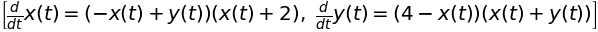

In [23]:
x = sym.Function('x')
y = sym.Function('y')
t = sym.Symbol("t")
eq1 = sym.Eq(x(t).diff(t),(2+x(t))*(y(t)-x(t)))
eq2 = sym.Eq(y(t).diff(t),(4-x(t))*(y(t)+x(t)))
[eq1, eq2]

Like before, we form a Matrix ready to compute the Jacobian:

In [24]:
FG = sym.Matrix([eq1.rhs, eq2.rhs])
FG

⎡(-x(t) + y(t))⋅(x(t) + 2)⎤
⎢                         ⎥
⎣(4 - x(t))⋅(x(t) + y(t)) ⎦

But first, we can use SymPy's `solve` function to find the critical points -- here, we find where `FG` is zero, which is equivalent to solving $x'=0, y'=0$:

In [74]:
sym.solve(FG)

Now we compute the Jacobian:

In [75]:
matJ = FG.jacobian([x(t), y(t)])
matJ

⎡-2⋅x(t) + y(t) - 2  x(t) + 2⎤
⎢                            ⎥
⎣-2⋅x(t) - y(t) + 4  4 - x(t)⎦

The linearisation about the critical point $(0,0)$ is then:

In [76]:
lin_mat = matJ.subs({x(t):0, y(t):0})
lin_mat

⎡-2  2⎤
⎢     ⎥
⎣4   4⎦

In [77]:
lin_mat * sym.Matrix([u(t),v(t)])

⎡-2⋅u(t) + 2⋅v(t)⎤
⎢                ⎥
⎣4⋅u(t) + 4⋅v(t) ⎦

Note that we can also use SymPy to help us determine the behaviour around this critical point, by computing the eigenvalues and eigenvectors:

In [78]:
lin_mat.eigenvects()

⎡⎛            ⎡⎡  -2    ⎤⎤⎞  ⎛            ⎡⎡  -2    ⎤⎤⎞⎤
⎢⎜            ⎢⎢────────⎥⎥⎟  ⎜            ⎢⎢────────⎥⎥⎟⎥
⎢⎜1 - √17, 1, ⎢⎢-3 + √17⎥⎥⎟, ⎜1 + √17, 1, ⎢⎢-√17 - 3⎥⎥⎟⎥
⎢⎜            ⎢⎢        ⎥⎥⎟  ⎜            ⎢⎢        ⎥⎥⎟⎥
⎣⎝            ⎣⎣   1    ⎦⎦⎠  ⎝            ⎣⎣   1    ⎦⎦⎠⎦

If we just want the eigenvalues, we can extract them more simply as:

In [79]:
evals = list(lin_mat.eigenvals().keys())
evals

In [80]:
list(map(sym.N, evals))

<span class="label label-danger">Task</span>
What is going on in this piece of code?

<div class="alert alert-info">
    <h3>Exercise 2.1</h3>

Find the linearisation about each of the other critical points, and compute the eigenvalues for the corresponding linear systems.

</div>

In [90]:
lin_mat_1 = matJ.subs({x(t):-2, y(t):2})
lin_mat_2 = matJ.subs({x(t):4, y(t):4})
lin_mat_1 * sym.Matrix([u(t),v(t)])
lin_mat_2 * sym.Matrix([u(t),v(t)])
lin_mat_1.eigenvects(),lin_mat_2.eigenvects()
#lin_mat_1.eigenvects() returns a Dict with keys as the eignevalues.
evals_1 = list(lin_mat_1.eigenvals().keys())
evals_2 = list(lin_mat_2.eigenvals().keys())
evals_1,evals_2

<div class="alert alert-info">
    <h3>Exercise 2.2</h3>

**(a)** Create two functions to carry out this process:

* `lin_matrix` which takes in a system of two equations (given as a list of SymPy Equations) and the coordinates of a point (given as a list), and returns the Jacobian matrix of the system evaluated at that point.

* `linearise` which takes in the same arguments, and returns a system of linear equations in $u$ and $v$

**(b)** Use your functions to solve problem 6 from section 9.3 of Boyce & DiPrima:

Find all the critical points of the system $$x'=x-x^2-xy,\quad y'=3y-xy-2y^2$$ and find the corresponding linear system near each critical point.

</div>

As an example, your functions in (a) should produce the following output using the equations defined in the previous example:

`lin_matrix([eq1,eq2],[0,0])`

$\displaystyle \left[\begin{matrix}-2 & 2\\4 & 4\end{matrix}\right]$

`linearise([eq1,eq2],[0,0])`

$\displaystyle \left[ \frac{d}{d t} u{\left(t \right)} = - 2 u{\left(t \right)} + 2 v{\left(t \right)}, \  \frac{d}{d t} v{\left(t \right)} = 4 u{\left(t \right)} + 4 v{\left(t \right)}\right]$


In [94]:
def lin_matrix(equations,coordinates):
    x = sym.Function('x')
    y = sym.Function('y')
    FG = sym.Matrix([equations[0].rhs, equations[1].rhs])
    matJ = FG.jacobian([x(t), y(t)])
    lin_mat = matJ.subs({x(t):coordinates[0], y(t):coordinates[1]})
    return (lin_mat)

lin_matrix([eq1,eq2],[0,0])

⎡-2  2⎤
⎢     ⎥
⎣4   4⎦

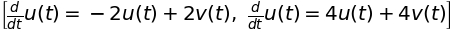

In [98]:
def linearise(equations,coordinates):
    lin_mat = lin_matrix(equations,coordinates)
    equ_u_v = lin_mat * sym.Matrix([u(t),v(t)])
    eq1 = sym.Eq(u(t).diff(t),equ_u_v[0])
    eq2 = sym.Eq(u(t).diff(t),equ_u_v[1])
    return [eq1, eq2]
    
linearise([eq1,eq2],[0,0])

## 3. Phase portraits

Plottng phase portraits can help to understand the behaviour of a nonlinear system, by showing what is happening to solution trajectories in the phase space and how this links to the linearised behaviour around the critical points.

We will base our approach on the sample code that Jacques provided in the `vectorFields.ipynb` notebook posted on Learn -- the following code comes from there, and shows a phase portrait for the pendulum (which was the first example in section 2, here with $\gamma=0, \omega=1$).

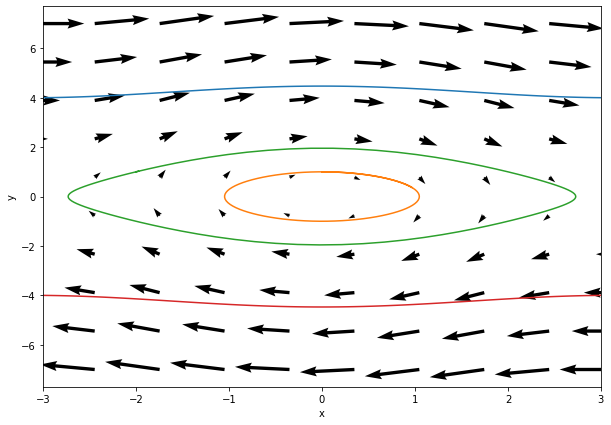

In [99]:
# Import packages

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

# Define vector field

def vField(x,t):
    u = x[1]
    v = -np.sin(x[0])
    return [u,v]

# Plot vector field

X, Y = np.mgrid[-np.pi:np.pi:10j,-7:7:10j]
U, V = vField([X,Y],0)

fig, ax = plt.subplots(figsize=(10, 7))
ax.quiver(X, Y, U, V)

# Compute and plot 4 trajectories

t=np.linspace(0,2,100)
x0, y0 = -3,4
x = odeint(vField,[x0,y0],t)
ax.plot(x[:,0],x[:,1]);

t=np.linspace(0,8,100)
x0, y0 = 0,1
x = odeint(vField,[x0,y0],t)
ax.plot(x[:,0],x[:,1]);

t=np.linspace(0,12,100)
x0, y0 = -2,1
x = odeint(vField,[x0,y0],t)
ax.plot(x[:,0],x[:,1]);

t=np.linspace(0,2,100)
x0, y0 = 3,-4
x = odeint(vField,[x0,y0],t)
ax.plot(x[:,0],x[:,1]);

# 

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-3,3)

plt.show()

Here we make several changes to the plot:

* increasing the plot area and using a finer grid,
* setting the colours using [colormaps](https://matplotlib.org/examples/color/colormaps_reference.html),
* changing some settings on the `quiver` which is used to produce the direction field, e.g. making the arrows centred at the points of the grid,
* using a loop to draw the trajectories,
* adding a few more trajectories to highlight features,
* adding points (in blue) to show where the trajectories started,
* adding the legend to the plot.

<span class="label label-danger">Task</span>
Make sure you can see all of these changes in the code. Play around with them by adjusting the various settings, e.g. make the grid more or less fine, change the scale of the arrows in the direction field, etc.

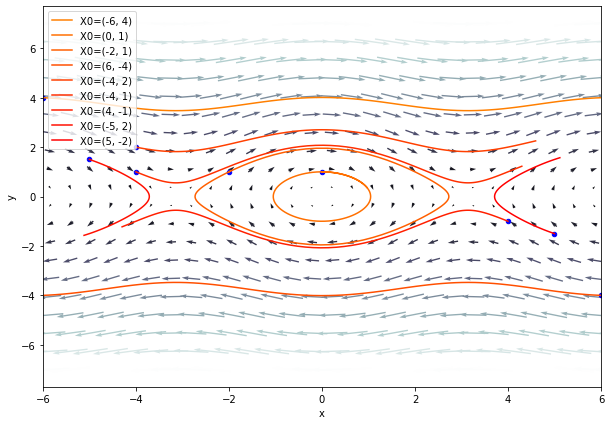

In [167]:
# Define vector field
def vField(x,t):
    u = x[1]
    v = -np.sin(x[0])
    return [u,v]

# Plot vector field
X, Y = np.mgrid[-2*np.pi:2*np.pi:30j,-7:7:20j]
U, V = vField([X,Y],0)

# define colours for each vector based on their lengths
M = np.hypot(U, V)

fig, ax = plt.subplots(figsize=(10, 7))
ax.quiver(X, Y, U, V, M, scale=1/0.01, pivot = 'mid', cmap = plt.cm.bone)

# Settings for trajectories
ics  = [[-6,4], [0,1], [-2,1], [6,-4], [-4,2], [-4, 1], [4, -1], [-5, 1.5], [5, -1.5]]
durations = [[0,4], [0,8], [0,12], [0,4], [0,4], [0,8], [0,8], [0,4], [0,4]]
vcolors = plt.cm.autumn_r(np.linspace(0.5, 1., len(ics)))  # colors for each trajectory

# plot trajectories
for i, ic in enumerate(ics):
    t = np.linspace(durations[i][0], durations[i][1],100)
    x = odeint(vField, ic, t)
    ax.plot(x[:,0], x[:,1], color=vcolors[i], label='X0=(%.f, %.f)' % (ic[0], ic[1]) )

ic_x = [ic[0] for ic in ics]
ic_y = [ic[1] for ic in ics]
ax.scatter(ic_x, ic_y, color='blue', s=20)
# note: you can replace ic_x, ic_y with *list(zip(*ics)) but this is a bit cryptic!

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-6,6)
plt.legend()

plt.show()

<div class="alert alert-info">
    <h3>Exercise 3.1</h3>

Produce phase portraits for the following systems in Workshop 5 Q1:

**(i)** $\mathbf{x}'=\begin{pmatrix}3 & -2\\2 & -2\end{pmatrix}\mathbf{x}$

**(iii)** $\mathbf{x}'=\begin{pmatrix}1 & -4\\4 & -7\end{pmatrix}\mathbf{x}$

</div>

_Hint:_ Choosing good starting points for the trajectories is a bit of an art; you will need to adjust the values that you pick to find the best ones. Note that you might also find that plotting the trajectories over a duration which is too long will cause the plot to break -- either you will get an error message saying the execution took too long, or you will find that the trajectory has shot well beyond the grid of arrows -- so you should adjust these values carefully too.

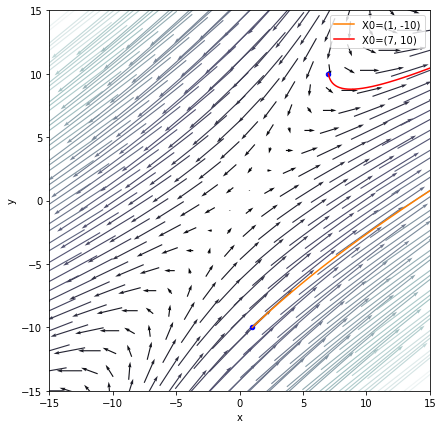

In [197]:
# Define vector field
def vField(x,t):
    u = 3*x[0]-2*x[1]
    v = 2*x[0]-2*x[1]
    return [u,v]

# Plot vector field
X, Y = np.mgrid[-15:15:20j,-15:15:20j]
U, V = vField([X,Y],0)

# define colours for each vector based on their lengths
M = np.hypot(U, V)

fig, ax = plt.subplots(figsize=(10, 7))
ax.quiver(X, Y, U, V, M, scale=1/0.005, pivot = 'mid', cmap = plt.cm.bone)

# Settings for trajectories
ics  = [[1,-10],[7,10]]
durations = [[0,3],[0,3]]
vcolors = plt.cm.autumn_r(np.linspace(0.5, 1., len(ics)))  # colors for each trajectory

# plot trajectories
for i, ic in enumerate(ics):
    t = np.linspace(durations[i][0], durations[i][1],100)
    x = odeint(vField, ic, t)
    ax.plot(x[:,0], x[:,1], color=vcolors[i], label='X0=(%.f, %.f)' % (ic[0], ic[1]) )

ic_x = [ic[0] for ic in ics]
ic_y = [ic[1] for ic in ics]
ax.scatter(ic_x, ic_y, color='blue', s=20)
# note: you can replace ic_x, ic_y with *list(zip(*ics)) but this is a bit cryptic!

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.legend()
plt.gca().set_aspect(1.0)

plt.show()

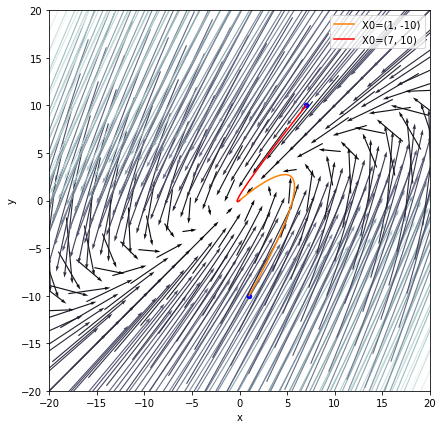

In [200]:
def vField(x,t):
    u = 1*x[0]-4*x[1]
    v = 4*x[0]-7*x[1]
    return [u,v]

# Plot vector field
X, Y = np.mgrid[-20:20:20j,-20:20:20j]
U, V = vField([X,Y],0)

# define colours for each vector based on their lengths
M = np.hypot(U, V)

fig, ax = plt.subplots(figsize=(10, 7))
ax.quiver(X, Y, U, V, M, scale=1/0.005, pivot = 'mid', cmap = plt.cm.bone)

# Settings for trajectories
ics  = [[1,-10],[7,10]]
durations = [[0,3],[0,3]]
vcolors = plt.cm.autumn_r(np.linspace(0.5, 1., len(ics)))  # colors for each trajectory

# plot trajectories
for i, ic in enumerate(ics):
    t = np.linspace(durations[i][0], durations[i][1],100)
    x = odeint(vField, ic, t)
    ax.plot(x[:,0], x[:,1], color=vcolors[i], label='X0=(%.f, %.f)' % (ic[0], ic[1]) )

ic_x = [ic[0] for ic in ics]
ic_y = [ic[1] for ic in ics]
ax.scatter(ic_x, ic_y, color='blue', s=20)
# note: you can replace ic_x, ic_y with *list(zip(*ics)) but this is a bit cryptic!

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.legend()
plt.gca().set_aspect(1.0)

plt.show()

<div class="alert alert-info">
    <h3>Exercise 3.2</h3>

Produce a phase portrait for the system we analysed in Exercise 2.2(b). Make sure you show the features around all of the critical points.

</div>
